## Data Wrangling (HAVG adapted from Unlocking Scientific Data by A. Collette)
###  Part 1: Python and HDF5

* Choices we make for organizing and storing Scientific data are also choices about communication
* Well-designed and defined formats makes life easier for individuals (towards sharing data with a global audience)
* Structured, "self-describing" formats like HDF5 are a natural complement to Python
* When verifying and plotting the data could be too much time consuming 
* Turning the raw-data into files the visualization tool could use

### Example 1: Weather station

In [97]:
import numpy
temperature=numpy.random.random(1024)
temperature

array([ 0.99246692,  0.45494691,  0.14992409, ...,  0.4722547 ,
        0.23373386,  0.68680984])

In [98]:
#Sampling details
dt=10.0    # seconds
start_time=300.0
source=15  # station name

### How to store this data?

Numpy! let's employ the *savez* function

In [96]:
numpy.savez("weather.npz", data=temperature,start_time=start_time,station=source)

retrieving data with *numpy.load*

In [100]:
out=numpy.load("weather.npz")
print out["data"]
print out["start_time"]
print out["station"]

[ 0.29271028  0.48475836  0.23665453 ...,  0.35702348  0.42172749
  0.53730089]
300.0
15


So far so good, but what if we add some new observables to every simulation?

In [101]:
wind=numpy.random.random(2048)
dt_wind=5.0
# Now suposse we run the same simulaitons for systems at different temperatures, hence:
# We will need NAMING CONVENTION LIKE: wind_15 or dt_wind_15 for the sampling interval

#### Example 1++: Weather station++

Now suposse we add more measurement station, hence:
* Well now my **Naming Convention** should look rather like *wind_15* and *dt_wind_15* plus sampling interval

In [102]:
# in contrast by using HDF5 we have:
import h5py
!rm weather.hdf5
f=h5py.File("weather.hdf5") # options could be added like 
f["/15/temperature"]=temperature
f["/15/temperature"].attrs["dt"]=10.0
f["/15/temperature"].attrs["start_time"]=300.0
f["/15/wind"]=wind
f["/15/wind"].attrs["dt"]=5.0
#f["/20/temperature"]=temperature_from_station_20


#### Options for creating hdf5 files
* r 	Readonly, file must exist
* r+ 	Read/write, file must exist
* w 	Create file, truncate if exists
* w- or x 	Create file, fail if exists
* a 	Read/write if exists, create otherwise (default)

# Main advantages of HDF5
* Organization in hierarchical groups 
    * Groups are: "/15" and "/20"
* Attributes
    * Adding descriptive metadata to the data, like dt, start_time


In [26]:
dataset=f["/15/temperature"]
for key,value in dataset.attrs.iteritems():
    print "%s: %s" % (key,value)

dt: 10.0
start_time: 300.0


## Coping and slicing data in HDF5

In [29]:
# HDF5 supports slicing like numpy
dataset=f["/15/temperature"]
print dataset[0:10]
print dataset[0:10:2]

[ 0.11461876  0.45016814  0.11850549  0.98391956  0.41114576  0.25181225
  0.29635385  0.94413288  0.70680089  0.81226172]
[ 0.11461876  0.11850549  0.41114576  0.29635385  0.70680089]


#### Remark: When slicing is done, data will be loaded into memory

## Storage control with HDF5

In [43]:
# let's generate a big dataset
#del(big_dataset)
big_dataset=f.create_dataset("big2", shape=(1024,1024,1024,512),dtype='float32')

In [44]:
big_dataset[344,678,23,36]=42.0

In [45]:
compressed_dataset=f.create_dataset("comp2",shape=(1024,),dtype='int32',compression='gzip')
compressed_dataset[:]=numpy.arange(1024)
compressed_dataset[:]

array([   0,    1,    2, ..., 1021, 1022, 1023], dtype=int32)

## What exactly is HDF5?
Is not a relational Database. HDF5 is a mechanism for storing large numerical arrays of homogeneous type, for data models that can be organized hierarchically and benefit from tagging of datasets with arbitrary metadata (in a binary format). It is actively maintained by the HDF group (http://www.hdfgroup.org)

#### Main advantage: high performance I/O access, hierarchical organization and arbitrary metadata

#### Three main elements of HDF5
* datasets
* array-like objects
* groups

In [47]:
f.keys()

[u'15', u'big', u'big2', u'comp', u'comp2']

In [48]:
f["/15"].keys()

[u'temperature', u'wind']

### Which is the HDF5 ecosystem?
Currently MATLAB uses it and Python, c++, among others, have bindings to HDF5

In [103]:
# Use of chunked storage
# How to explore the features of h5py
# explore properties and methods existing on the File object
h5py.File.

In [53]:
### Working with Datasets (+ allows to read slices of data wo opening all as a block) you can use standard NumPy syntax
f=h5py.File("testfile.hdf5")

In [ ]:
arr=numpy.ones((5,2))
f["my dataset"]=arr
dset=f["my dataset"]
dset
# We entered a NumPy array but got back somth else: an instance of the class h5py.Dataset. This i a "proxy" object
# that lets you read and write to the underlying HDF5 dataset on disk.

In [56]:
dset.dtype

dtype('float64')

In [57]:
dset.shape

(5, 2)

In [60]:
out=dset[...]
out

array([[ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.],
       [ 1.,  1.]])

In [64]:
dset[1:4,1]=2.0
dset[...]

array([[ 1.,  1.],
       [ 1.,  2.],
       [ 1.,  2.],
       [ 1.,  2.],
       [ 1.,  1.]])

### How chunking and compression can help You
* How muldimensional arrays are handled in Python and HDF5?
* How is our data stored in the disks?

In [68]:
# Contiguous Storage
a=numpy.array([["A","B"],["C","D"]])
print a

[['A' 'B']
 ['C' 'D']]


In [73]:
a[1,1]   # Mathematically it is a Matrix

'D'

However the computer memory is stored in a one dimensional "Buffer" like

*'A' 'B' 'C' 'D'*

In [75]:
#Buffer Offset for a[0,1]
rowsWeight=2
colsWeight=1
rowsValue=0
colsValue=1
offset=rowsWeight*rowsValue+colsWeight*colsValue
offset

1

### Example 2: Image processing

In [76]:
f=h5py.File("imagetest.hdf5")
dset=f.create_dataset("Images",(100,480,640),dtype='uint8')

In [77]:
oneImage=dset[0,:,:]
oneImage.shape

(480, 640)

In [78]:
#tiling image to add figure name or identifier
tile=dset[0,0:64,0:64]
tile.shape


(64, 64)

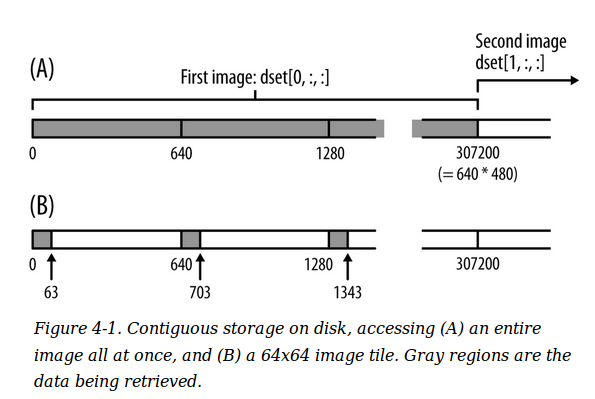

In [124]:
from IPython.display import Image
Image(filename='zero.png')

#### What if we only want to load the 64x64 chunks all the time, could we group data like that in hdf5?

In [84]:
dset=f.create_dataset('chunked2',(100,480,640),dtype='uint8',chunks=(1,64,64))

In [85]:
dset.chunks

(1, 64, 64)

### Auto-Chunking

In [86]:
dset=f.create_dataset("Images2",(100,480,640),'f',chunks=True)

In [87]:
dset.chunks   # good if it is in the order of a couple KBytes

(7, 30, 80)

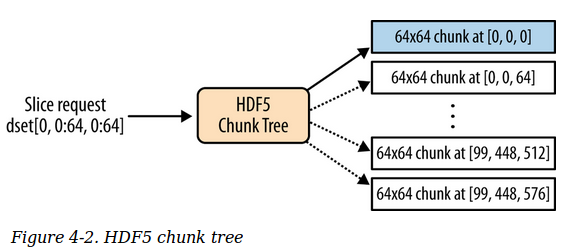

In [126]:
Image(filename='one.png')

### Compression

In [113]:
dset=f.create_dataset("BiggishDataSet3",(1000,1000),dtype='f',compression="gzip")
dset.compression

'gzip'

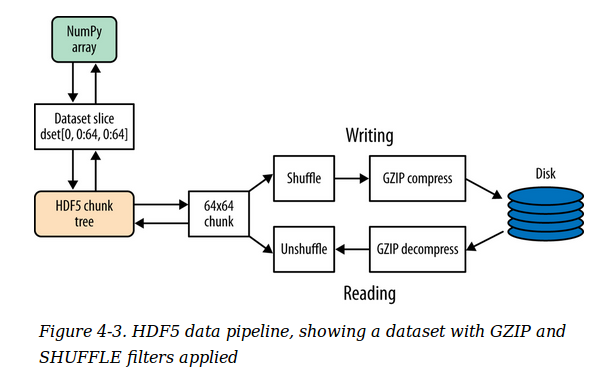

In [125]:
Image(filename='two.png')

Compression is transparent; data is read and written normally

In [114]:
dset[...]=42.0
dset[999,999]

42.0

In [115]:
#More compression options
dset.compression_opts
dset.chunks

(63, 125)

In [121]:
dset=f.create_dataset("BiggishDataSet5",(1000,1000),dtype='f',compression=9)


In [122]:
dset.compression_opts

9

In [123]:
dset.chunks

(63, 125)